In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# 1.Load data

In [2]:
input_folder = Path("../results/HD_DIT_HAP/11_merged")

raw_reads = {}
for file in input_folder.glob("*.tsv"):
    sample_name = file.stem.split(".")[0]
    raw_reads[sample_name] = pd.read_csv(file, header=0, index_col=[0, 1, 2, 3], sep="\t")

output_folder = Path("../tmp/reads_filter_test")
output_folder.mkdir(parents=True, exist_ok=True)

In [2]:
annotations = pd.read_csv("../results/HD_DIT_HAP/Two_replicates_and_imputation/13_concatenated/annotations.tsv", sep="\t", index_col=[0,1,2,3])

in_gene_indexes = annotations.query("Type != 'Intergenic region' and Distance_to_stop_codon > 4").index

# 2.Concat data

In [4]:
concated_reads = pd.concat(raw_reads, axis=1)

# 3. Filtering

In [5]:
YES0_reads = concated_reads.xs("YES0", level=1, axis=1)

In [6]:
filtered_YES0 = YES0_reads[YES0_reads.max(axis=1) > 16].copy()

In [7]:
first_indexes = (filtered_YES0 > 16).sum(axis=1).to_frame("Count").query("Count == 3").index
second_indexes = (filtered_YES0 > 8).sum(axis=1).to_frame("Count").query("Count == 3").index
third_indexes = (filtered_YES0 > 4).sum(axis=1).to_frame("Count").query("Count == 3").index
fourth_indexes = (filtered_YES0 > 2).sum(axis=1).to_frame("Count").query("Count == 3").index

In [8]:
print(">16: ", len(first_indexes))
print(">8: ", len(second_indexes))
print(">4: ", len(third_indexes))
print(">2: ", len(fourth_indexes))

print(">8 but not >16 in gene: ", annotations[annotations.index.isin(in_gene_indexes) & annotations.index.isin(second_indexes.difference(first_indexes))].shape[0])
print(">4 but not >8 in gene: ", annotations[annotations.index.isin(in_gene_indexes) & annotations.index.isin(third_indexes.difference(second_indexes))].shape[0])
print(">2 but not >4 in gene: ", annotations[annotations.index.isin(in_gene_indexes) & annotations.index.isin(fourth_indexes.difference(third_indexes))].shape[0])

>16:  78169
>8:  79960
>4:  81351
>2:  82974
>8 but not >16 in gene:  623
>4 but not >8 in gene:  501
>2 but not >4 in gene:  688


In [9]:
selected_index = filtered_YES0[filtered_YES0.notna().all(axis=1) & (filtered_YES0.median(axis=1)>16)].index

# 5.In gene insertion analysis

In [10]:
in_gene_reads = filtered_YES0[filtered_YES0.index.isin(in_gene_indexes)].copy()

In [11]:
(in_gene_reads > 16).sum(axis=1).value_counts()

1    28732
3    22790
2    17380
Name: count, dtype: int64

In [12]:
(in_gene_reads > 8).sum(axis=1).value_counts()

1    27998
3    23413
2    17491
Name: count, dtype: int64

In [13]:
in_gene_reads.isna().sum(axis=1).value_counts()

0    43003
1    16097
2     9802
Name: count, dtype: int64

In [14]:
test_filtering_in_gene_insertions = pd.concat([in_gene_reads[in_gene_reads.notna().all(axis=1) & (in_gene_reads.median(axis=1)>16)], in_gene_reads[(in_gene_reads.notna().sum(axis=1)==2) & (in_gene_reads.min(axis=1)>16)]], axis=0)

In [15]:
current_imputation_insertions = pd.read_csv("../results/HD_DIT_HAP/14_imputed_missing_values_using_FR/imputed_raw_reads.tsv", header=[0,1], index_col=[0,1,2,3], sep="\t")

In [18]:
current_imputation_in_gene_insertions = current_imputation_insertions[current_imputation_insertions.index.isin(in_gene_indexes)]

In [19]:
different_indexes = [ idx for idx in test_filtering_in_gene_insertions.index if idx not in current_imputation_in_gene_insertions.index]

In [20]:
annotations[annotations.index.isin(different_indexes)]["Name"].value_counts().to_frame().query("count > 2")

,count
Name,
dhc1,29
tra1,20
vps1301,17
mdn1,14
tel1,14
...,...
ubp12,3
mms1,3
sty1,3


In [3]:
cutoff16_gene_level_statistics = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/Strict_filtering_results/18_gene_level_curve_fitting/Gene_level_statistics_fitted.csv", index_col=[0,1,2,3])
cutoff8_gene_level_statistics = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv", index_col=[0,1,2,3], sep="\t")

In [4]:
concated_gene_level_statistics = pd.concat([cutoff16_gene_level_statistics, cutoff8_gene_level_statistics], axis=1, keys=["Cutoff16", "Cutoff8"])

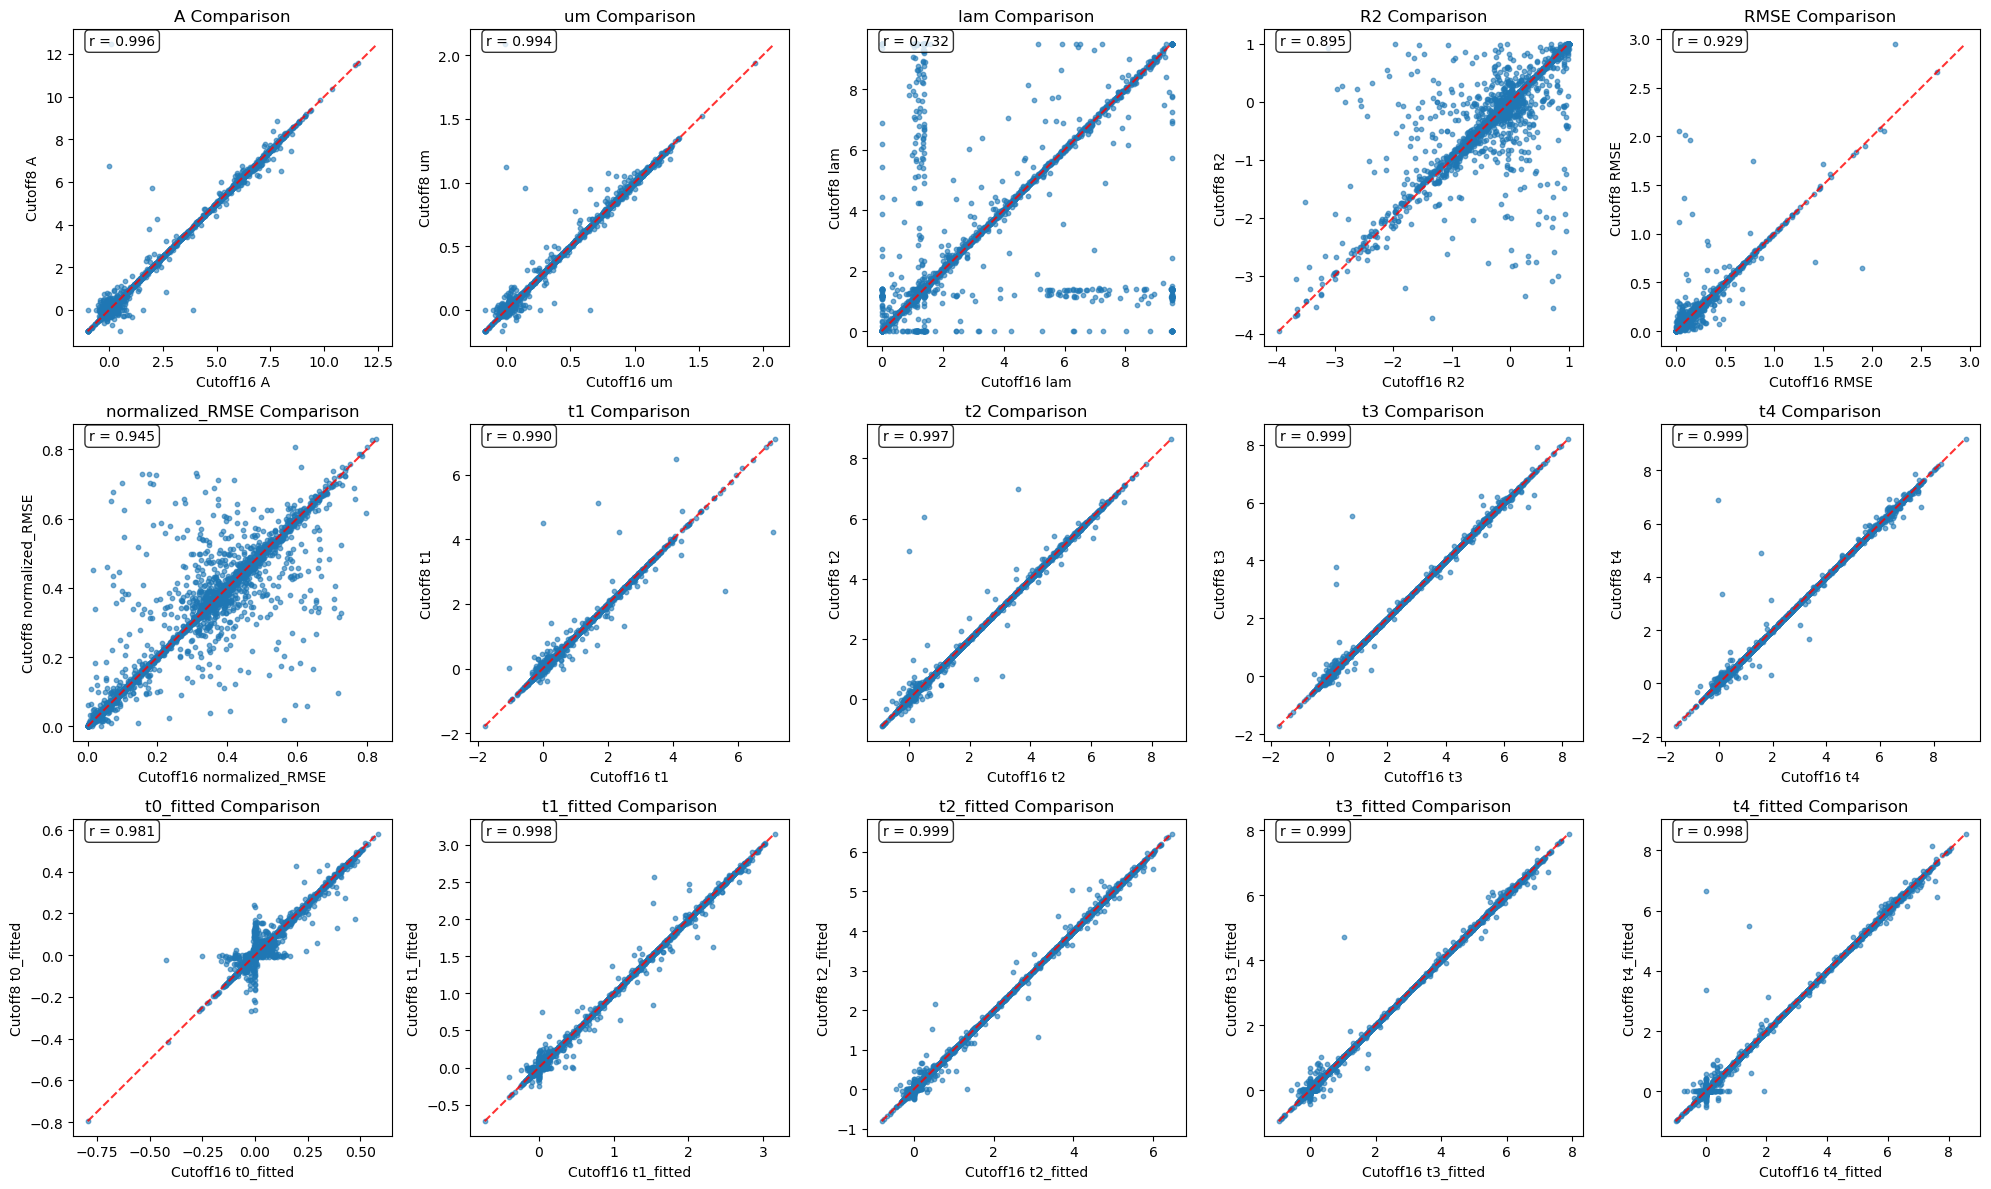

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the columns to compare
columns_to_compare = ['A', 'um', 'lam', 'R2', 'RMSE', 'normalized_RMSE',
                      't1', 't2', 't3', 't4',
                      't0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted']

# Create subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(columns_to_compare):
    ax = axes[i]
    
    # Get data for both cutoffs
    cutoff16_data = concated_gene_level_statistics[('Cutoff16', col)]
    cutoff8_data = concated_gene_level_statistics[('Cutoff8', col)]
    
    # Remove NaN values for plotting
    mask = ~(cutoff16_data.isna() | cutoff8_data.isna())
    x_data = cutoff16_data[mask]
    y_data = cutoff8_data[mask]
    
    # Create scatter plot
    ax.scatter(x_data, y_data, alpha=0.6, s=10)
    
    # Add diagonal line for reference
    min_val = min(x_data.min(), y_data.min())
    max_val = max(x_data.max(), y_data.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    
    # Set labels and title
    ax.set_xlabel(f'Cutoff16 {col}')
    ax.set_ylabel(f'Cutoff8 {col}')
    ax.set_title(f'{col} Comparison')
    
    # Add correlation coefficient
    corr = np.corrcoef(x_data, y_data)[0, 1]
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [16]:
idx = pd.IndexSlice
concated_gene_level_statistics[(concated_gene_level_statistics["Cutoff16"]['A'] - concated_gene_level_statistics["Cutoff8"]['A']).abs() > 2].loc[idx[:,:,:,:], idx[:, ['A', 'um', 'lam', 'R2', 't1', 't2', 't3', 't4']]]

Cutoff16  \
                                                                           A   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality            
SPAC17G8.12   sec3 condition-dependent E                               1.970   
SPAC1F3.02c   mkh1 viable              Not_determined                 -0.006   
SPAC664.02c   arp8 viable              V                               2.232   
SPBC216.02    num1 viable              V                               0.082   
SPBC4C3.06    syp1 viable              V                               3.908   

                                                                            \
                                                                        um   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             0.147   
SPAC1F3.02c   mkh1 viable              Not_determined                0.001   
SPAC664.02c   arp8 viable              V                             0.374   
SPBC216.02    num1 viable              V                            -0.006   
SPBC4C3.06    syp1 viable              V                             0.655   

                                                                            \
                                                                       lam   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             2.061   
SPAC1F3.02c   mkh1 viable              Not_determined                1.161   
SPAC664.02c   arp8 viable              V                             4.715   
SPBC216.02    num1 viable              V                             1.380   
SPBC4C3.06    syp1 viable              V                             9.511   

                                                                            \
                                                                        R2   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             0.943   
SPAC1F3.02c   mkh1 viable              Not_determined               -1.964   
SPAC664.02c   arp8 viable              V                             0.982   
SPBC216.02    num1 viable              V                            -0.044   
SPBC4C3.06    syp1 viable              V                             0.998   

                                                                            \
                                                                        t1   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             0.235   
SPAC1F3.02c   mkh1 viable              Not_determined                0.118   
SPAC664.02c   arp8 viable              V                             0.114   
SPBC216.02    num1 viable              V                             0.017   
SPBC4C3.06    syp1 viable              V                             0.026   

                                                                            \
                                                                        t2   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             0.583   
SPAC1F3.02c   mkh1 viable              Not_determined                0.066   
SPAC664.02c   arp8 viable              V                             0.241   
SPBC216.02    num1 viable              V                            -0.017   
SPBC4C3.06    syp1 viable              V                             0.007   

                                                                            \
                                                                        t3   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                            

In [18]:
concated_gene_level_statistics[(concated_gene_level_statistics["Cutoff16"]['um'] - concated_gene_level_statistics["Cutoff8"]['um']).abs() > 0.3].loc[idx[:,:,:,:], idx[:, ['A', 'um', 'lam', 'R2', 't1', 't2', 't3', 't4']]]

Cutoff16  \
                                                                           A   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality            
SPAC17G8.12   sec3 condition-dependent E                               1.970   
SPAC1F3.02c   mkh1 viable              Not_determined                 -0.006   
SPBC216.02    num1 viable              V                               0.082   
SPBC4C3.06    syp1 viable              V                               3.908   
SPCC1223.06   tea1 viable              V                               2.649   

                                                                            \
                                                                        um   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             0.147   
SPAC1F3.02c   mkh1 viable              Not_determined                0.001   
SPBC216.02    num1 viable              V                            -0.006   
SPBC4C3.06    syp1 viable              V                             0.655   
SPCC1223.06   tea1 viable              V                             0.373   

                                                                            \
                                                                       lam   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             2.061   
SPAC1F3.02c   mkh1 viable              Not_determined                1.161   
SPBC216.02    num1 viable              V                             1.380   
SPBC4C3.06    syp1 viable              V                             9.511   
SPCC1223.06   tea1 viable              V                             8.381   

                                                                            \
                                                                        R2   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             0.943   
SPAC1F3.02c   mkh1 viable              Not_determined               -1.964   
SPBC216.02    num1 viable              V                            -0.044   
SPBC4C3.06    syp1 viable              V                             0.998   
SPCC1223.06   tea1 viable              V                             0.896   

                                                                            \
                                                                        t1   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             0.235   
SPAC1F3.02c   mkh1 viable              Not_determined                0.118   
SPBC216.02    num1 viable              V                             0.017   
SPBC4C3.06    syp1 viable              V                             0.026   
SPCC1223.06   tea1 viable              V                             0.077   

                                                                            \
                                                                        t2   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                             0.583   
SPAC1F3.02c   mkh1 viable              Not_determined                0.066   
SPBC216.02    num1 viable              V                            -0.017   
SPBC4C3.06    syp1 viable              V                             0.007   
SPCC1223.06   tea1 viable              V                             0.384   

                                                                            \
                                                                        t3   
Systematic ID Name FYPOviability       DeletionLibrary_essentiality          
SPAC17G8.12   sec3 condition-dependent E                            

In [8]:
concated_gene_level_statistics[concated_gene_level_statistics["Cutoff16"]["A"].isna()]["Cutoff8"][["A", "um", "lam", "R2", "t1", "t2", "t3", "t4"]]

,,,,A,um,lam,R2,t1,t2,t3,t4
Systematic ID,Name,FYPOviability,DeletionLibrary_essentiality,,,,,,,,
SPAC1006.05c,och1,viable,V,5.759,0.965,1.008,0.882,0.841,5.036,3.950,6.063
SPAC12B10.15c,rnh203,viable,V,-0.622,-0.041,0.387,0.938,-0.161,-0.171,-0.339,-0.477
SPAC13D1.01c,Tf2-7,unknown,Not_determined,-0.654,-0.110,-0.000,0.439,-0.622,-0.551,-0.534,-0.577
SPAC23C4.15,rpb5,inviable,E,8.980,0.753,1.935,0.977,1.224,2.204,5.748,6.841
SPAC2E1P3.03c,Tf2-3,unknown,Not_determined,0.513,0.086,-0.000,-0.042,1.038,-0.428,1.146,0.231
SPAC5D6.08c,mes1,viable,V,0.231,0.039,-0.000,0.324,0.158,0.328,0.097,0.208
SPAC9.04,Tf2-1,unknown,Not_determined,0.358,0.060,3.798,0.523,-0.230,0.024,0.518,0.172
SPAC9G1.12,trm61,viable,V,1.850,0.170,0.800,0.921,0.455,0.584,1.543,1.498
SPAPB15E9.03c,Tf2-5,unknown,Not_determined,1.509,0.253,-0.000,0.643,1.112,1.383,1.576,1.037
